In [ ]:
import numpy as np
from PIL import Image

In [ ]:
projection_bin = "data/ball_view/short_throw_depth_camera_space_projection-1.bin"
image_height = 450
image_width = 448

In [ ]:
def get_cam_space_projection(projection_bin, depth_h, depth_w):
    # read binary file
    projection = np.fromfile(projection_bin, dtype = np.float32)
    x_list = [projection[i] for i in range(0,len(projection),2)]
    y_list = [projection[i] for i in range(1,len(projection),2)]
    
    # rearrange as array
    u = np.asarray(x_list).reshape(depth_w,depth_h).T
    v = np.asarray(y_list).reshape(depth_w,depth_h).T

    return [u, v]

In [ ]:
u, v = get_cam_space_projection(projection_bin, image_height, image_width )

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(v)

In [ ]:
depth_values_file = "data/chair_view/short_throw_depth (2)/short_throw_depth\\00131957160949186890.pgm"

In [ ]:
depth_values = np.fromfile(depth_values_file, dtype = np.float32)

In [ ]:
from PIL import Image

In [ ]:
im = Image.open(depth_values_file)
print(im.size) # Height width is swapped from the original case
depth_values = im.load()
im

In [ ]:
def get_camera_view_pts(depth_values, u, v):
    output_frame = np.zeros((450, 448))
    unscaled_frame = np.zeros((450, 448))
    for i in range(448):
        for j in range(450):
            if depth_values[i,j] > 64000:
                continue
            output_frame[j][i] = depth_values[i,j]
            unscaled_frame[j][i] = -1.0 * output_frame[j][i] / np.sqrt(u[j][i]**2 + v[j][i]**2 + 1)
    eff_frame = unscaled_frame/1000
    x_pts = u * eff_frame
    y_pts = v * eff_frame
    z_pts = eff_frame
    return np.stack((x_pts.reshape(-1), y_pts.reshape(-1), z_pts.reshape(-1)), axis=1)

In [ ]:
# DEPRECATED
# %matplotlib inline
# import matplotlib.pyplot as plt
# from mpl_toolkits.mplot3d import Axes3D
# xyz = np.stack((xdata,ydata,zdata), axis=1)
# xyz_ones = np.ones((xyz.shape[0], xyz.shape[1]+1))
# xyz_ones[:,:-1]= xyz
# results = np.dot(camera_view_transform_inverse, xyz_ones.T).T
# print(results.shape)
# fig = plt.figure(figsize=(20,20))
# ax = plt.axes(projection='3d')
# ax.scatter3D(xdata, ydata, zdata)
# # ax.scatter3D(results[:,0],results[:,1], results[:,2])
# fig.savefig("test",dpi=420, figsize=(10,10))
# plt.savefig("test3",dpi=420, figsize=(10,10),s=1)

### Following would be the utility for moving to world space. See if different frames align together in this space.

In [72]:
# Read the csv file containing the Transform matrices
# csv_path = "data/ball-2/short_throw_depth-3-2.csv"
def get_frame_matrix(csv_path, image_num):
    """
    Returns Camera To World Matrix, Timestamp of Image
    """
    with open(csv_path, "r") as csv_file:
        header = csv_file.readline()
        for line in csv_file:
            line = line.strip()
            if not line:
                continue
            elems = line.split(",")
            if elems[1].split("\\")[1] == image_num:
                frame_to_origin = np.array(list(map(float, elems[2:18])))
                frame_to_origin = frame_to_origin.reshape(4,4).T
                print("Frame to origin")
                print(frame_to_origin)
                camera_view = np.array(list(map(float, elems[18:34])))
                camera_view = camera_view.reshape(4,4).T
                print("camera View")
                print(camera_view)
                # camera_projection -> camera_view -> world state
                camera_to_image = np.array(
                                    [[1, 0, 0, 0], [0, -1, 0, 0], [0, 0, -1, 0], [0, 0, 0, 1]])
                world_to_camera_view = np.dot(
                    camera_to_image,
                    np.dot(camera_view, np.linalg.inv(frame_to_origin)))
                world_to_camera_view = np.dot(camera_view,np.linalg.inv(frame_to_origin))
#                 camera_view_to_world = np.dot(frame_to_origin, np.linalg.inv(camera_view))
                return np.linalg.inv(world_to_camera_view), float(elems[0])
#                 return camera_view_to_world, float(elems[0])

In [73]:
# Map camera view points to world
def map_points_to_world(camera_view_pts, world_matrix):
    """
    Camera View Points will be nx3. Will add a column of 1s to make it nx4.
    """
    camera_view_pts_ones = np.ones((camera_view_pts.shape[0], camera_view_pts.shape[1]+1))
    camera_view_pts_ones[:,:-1]= camera_view_pts
    return np.dot(world_matrix, camera_view_pts_ones.T).T

(448, 450)


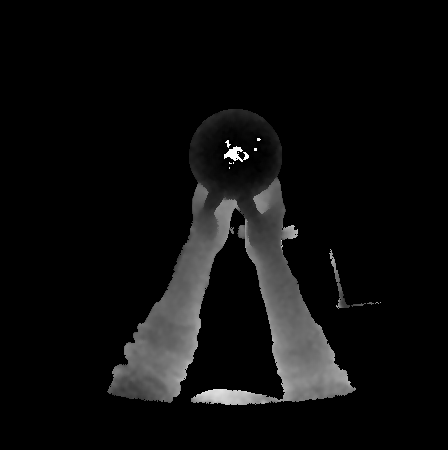

In [74]:
image_number = "00131957199438912227.pgm"
depth_values_file = "data/ball-2/" + image_number
depth_values = np.fromfile(depth_values_file, dtype = np.float32)
im = Image.open(depth_values_file)
print(im.size) # Height width is swapped from the original case
depth_values = im.load()
im

In [75]:

u, v = get_cam_space_projection(projection_bin, image_height, image_width )
camera_view_pts = get_camera_view_pts(depth_values, u, v)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in multiply
  # This is added back by InteractiveShellApp.init_path()
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in multiply
  if sys.path[0] == '':


In [76]:
camera_view_to_world,_ = get_frame_matrix(csv_path, image_number)

NameError: name 'csv_path' is not defined

In [ ]:
world_coordinates = map_points_to_world(camera_view_pts, camera_view_to_world)
world_coordinates_3d = (world_coordinates / world_coordinates[:,-1][:,None])[:,:-1]
np.savetxt("pts/camera_view_coordinates.csv", camera_view_pts, delimiter=",")
np.savetxt("pts/world_coordinates.csv", world_coordinates_3d , delimiter=",")

In [ ]:
# This is to generate the room using Long ToF
from os import listdir
import os
from tqdm import tqdm
projection_bin = "data/chair_view/short_throw_depth_camera_space_projection-2.bin"
directory = "data/chair_view/short_throw_depth (2)"
image_height = 450
image_width = 448
u, v = get_cam_space_projection(projection_bin, image_height, image_width )
files = listdir(directory)
pointcloud = []
for i in tqdm(range(0,len(files)-30,30)):
    file = files[i]
    image_number = file.split("\\")[1]
    depth_values_file = os.path.join(directory, file)
    depth_values = np.fromfile(depth_values_file, dtype = np.float32)
    im = Image.open(depth_values_file)
    depth_values = im.load()
    camera_view_pts = get_camera_view_pts(depth_values, u, v)
    camera_view_to_world, _= get_frame_matrix(csv_path, image_number)
    world_coordinates = map_points_to_world(camera_view_pts, camera_view_to_world)
    world_coordinates_3d = (world_coordinates / world_coordinates[:,-1][:,None])[:,:-1]
    pointcloud.append(world_coordinates_3d)
    break
    


In [ ]:
world_pts = np.concatenate(pointcloud)
np.savetxt("pts/world_coordinates.csv", world_pts , delimiter=",")

### RGB data with Depth data

In [77]:
# To overlay Picture Video Stream on top of Point Cloud
# This will not work for the last timestamp
# def get_closest_pv(timestamp, pv_csv_path):
#     min_difference = float('inf')
#     last_elems = None
#     i = 0
#     with open(pv_csv_path, "r") as csv_file:
#         header = csv_file.readline()
#         for line in csv_file:
#             line = line.strip()
#             if not line:
#                 continue
#             elems = line.split(",")
#             pv_time = float(elems[0])
#             diff = abs(pv_time - timestamp)
#             if diff > min_difference:
#                 # Use the last tf
#                 pv_elems = last_elems
#                 pv_image_num = pv_elems[1]
#                 frame_to_origin = np.array(list(map(float, pv_elems[2:18])))
#                 frame_to_origin = frame_to_origin.reshape(4,4)
#                 camera_view = np.array(list(map(float, pv_elems[18:34])))
#                 camera_view = camera_view.reshape(4,4)
#                 camera_projection = np.array(list(map(float, pv_elems[34:50])))
#                 camera_projection = camera_projection.reshape(4,4)
#                 # camera_projection -> camera_view -> world state
#                 world_to_camera_view = np.dot(camera_view, np.linalg.inv(frame_to_origin))
#                 print(i)
#                 return world_to_camera_view, camera_projection, pv_image_num, frame_to_origin
#             else:
#                 min_difference = diff
#                 last_elems = elems
#                 i+=1

def get_closest_pv(timestamp, pv_csv_path):
    min_difference = float('inf')
    last_elems = None
    i = 0
    with open(pv_csv_path, "r") as csv_file:
        header = csv_file.readline()
        for line in csv_file:
            line = line.strip()
            if not line:
                continue
            elems = line.split(",")
            pv_time = float(elems[0])
            diff = abs(pv_time - timestamp)
            if diff > min_difference:
                # Use the last tf
                pv_elems = last_elems
                pv_image_num = pv_elems[1]
                frame_to_origin = np.array(list(map(float, pv_elems[2:18])))
                frame_to_origin = frame_to_origin.reshape(4,4).T
                print(frame_to_origin)
                camera_view = np.array(list(map(float, pv_elems[18:34])))
                camera_view = camera_view.reshape(4,4).T
                print(camera_view)
                camera_projection = np.array(list(map(float, pv_elems[34:50])))
                camera_projection = camera_projection.reshape(4,4)
                print("camera projection")
                print(camera_projection)
                # camera_projection -> camera_view -> world state
#                 world_to_camera_view = np.dot(camera_view, np.linalg.inv(frame_to_origin))
                camera_to_image = np.array(
                                    [[1, 0, 0, 0], [0, -1, 0, 0], [0, 0, -1, 0], [0, 0, 0, 1]])
#                 world_to_camera_view = np.dot(
#                     camera_to_image,
#                     np.dot(camera_view, np.linalg.inv(frame_to_origin)))
                world_to_camera_view = np.dot(camera_view, np.linalg.inv(frame_to_origin))
#                 print(world_to_camera_view)
                return world_to_camera_view, camera_projection, pv_image_num, frame_to_origin
            else:
                min_difference = diff
                last_elems = elems
                i+=1
                

(448, 450)


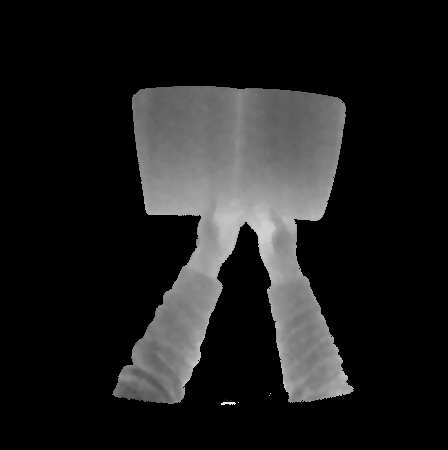

In [92]:
# Open Depth Image
image_number = "00131957046172503057.pgm"
depth_values_file = "data/book_view/" + image_number
depth_values = np.fromfile(depth_values_file, dtype = np.float32)
im = Image.open(depth_values_file)
print(im.size) # Height width is swapped from the original case
depth_values = im.load()
im

In [93]:
# Get camera matrix (Camera view -> World) for depth data and associated timestamp
depth_csv_path = "data/book_view/short_throw_depth-2.csv"
camera_view_to_world, timestamp = get_frame_matrix(depth_csv_path, image_number)

Frame to origin
[[ 9.57909e-01  4.24355e-04  2.87074e-01 -1.06511e-02]
 [-3.93271e-04  1.00000e+00 -1.67672e-04 -2.27247e-02]
 [-2.87074e-01  4.81345e-05  9.57910e-01  7.71536e-03]
 [ 0.00000e+00  0.00000e+00  0.00000e+00  1.00000e+00]]
camera View
[[ 9.99896e-01 -1.43494e-02 -1.56670e-03 -5.67096e-04]
 [ 9.16378e-03  7.14908e-01 -6.99160e-01 -1.83058e-01]
 [ 1.11519e-02  6.99072e-01  7.14966e-01  5.58858e-02]
 [ 0.00000e+00  0.00000e+00  0.00000e+00  1.00000e+00]]


In [94]:
# Find the closts PV image and its assocaited matrices
pv_csv_path = "data/book_view/pv (1).csv"
world_to_camera_view_pv, camera_projection_pv, image_number_pv, frame_to_origin_pv = get_closest_pv(timestamp, pv_csv_path)
# print(camera_projection_pv)

[[ 9.29847e-01  4.23014e-04  3.67947e-01 -1.09093e-02]
 [-3.76016e-04  1.00000e+00 -2.00786e-04 -2.28067e-02]
 [-3.67947e-01  4.87082e-05  9.29848e-01  8.02235e-03]
 [ 0.00000e+00  0.00000e+00  0.00000e+00  1.00000e+00]]
[[ 9.96602e-01 -6.36135e-03  8.21228e-02 -7.23758e-04]
 [ 2.27012e-02  9.79612e-01 -1.99615e-01 -1.00679e-01]
 [-7.91791e-02  2.00801e-01  9.76428e-01  1.44853e-01]
 [ 0.00000e+00  0.00000e+00  0.00000e+00  1.00000e+00]]
camera projection
[[ 2.43899    0.         0.         0.       ]
 [ 0.         4.33065    0.         0.       ]
 [ 0.0780145 -0.0625594 -1.        -1.       ]
 [ 0.         0.         0.         0.       ]]


(1280, 720)


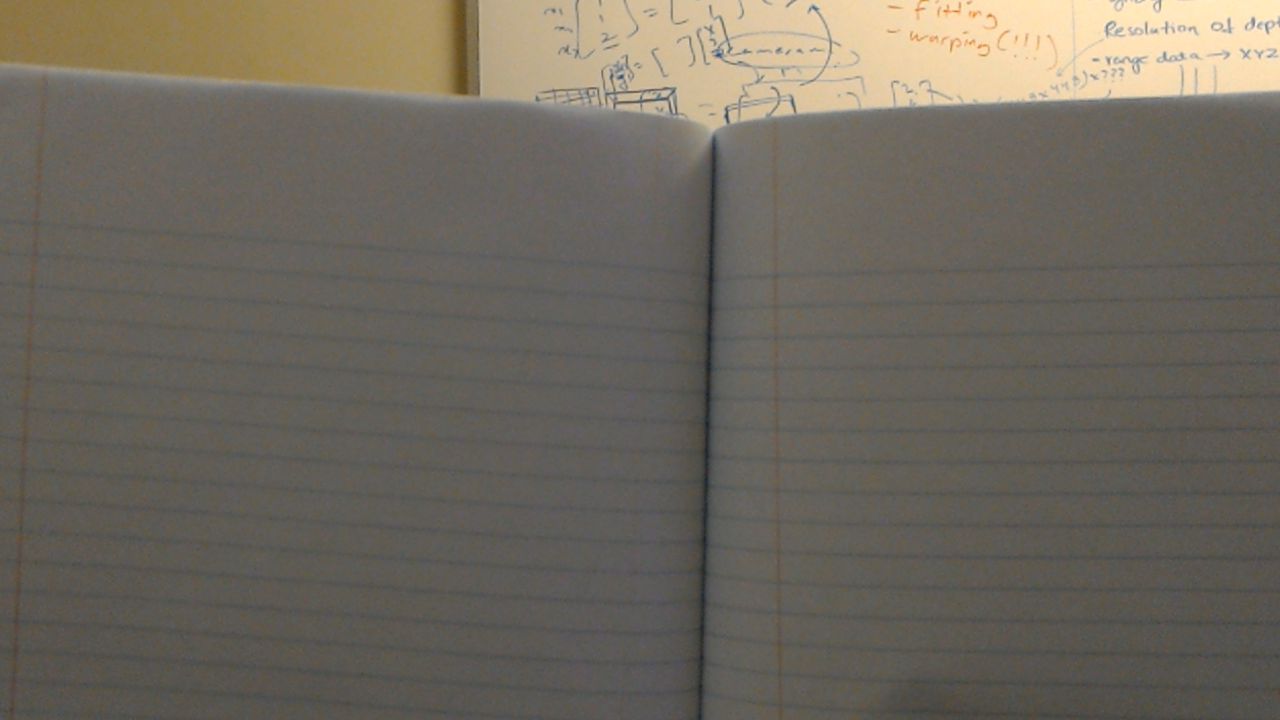

In [95]:
# Display the PV image
pv_file = "data/book_view/pv (1)/" + image_number_pv
im = Image.open(pv_file)
print(im.size) # Height width is swapped from the original case
pv_values = im.load()
im

In [96]:
# Open Depth UnProjection Pixel Values. Projection Pixel Values are to be used since we do
# not have access to the intrinsic matrix for Depth Sensors.
projection_bin = "data/book_view/short_throw_depth_camera_space_projection-1.bin"
image_height = 450
image_width = 448
u, v = get_cam_space_projection(projection_bin, image_height, image_width )

In [97]:
# Get Camera View Points by performing unprojection for depth data (Camera Projection Coordinate -> Camera View Coordinate)
camera_view_pts = get_camera_view_pts(depth_values, u, v)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in multiply
  # This is added back by InteractiveShellApp.init_path()
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in multiply
  if sys.path[0] == '':


In [98]:
# Get world coordinates for depth data
world_coordinates = map_points_to_world(camera_view_pts, camera_view_to_world)
world_coordinates_3d = world_coordinates[:,:-1]
# world_coordinates_3d = (world_coordinates / world_coordinates[:,-1][:,None])[:,:-1]
np.savetxt("pts/camera_view_coordinates.csv", camera_view_pts, delimiter=",")
np.savetxt("pts/world_coordinates.csv", world_coordinates_3d , delimiter=",")

In [99]:
# Map this world data onto the PV camera pixel map
world_coordinates_pts_ones = np.ones((world_coordinates_3d.shape[0], world_coordinates_3d.shape[1]+1))
world_coordinates_pts_ones[:,:-1]= world_coordinates_3d
camera_view_pv = np.dot(world_to_camera_view_pv, world_coordinates_pts_ones.T).T # 4 x N
# camera_view_pv = (camera_view_pv / camera_view_pv[:,-1][:,None])
# camera_view_pv = (camera_view_pv / camera_view_pv[:,-2][:,None])
print(camera_view_pv.shape)
camera_view_pv[:,-1] = np.ones(camera_view_pv.shape[0])
print(camera_view_pv.shape)
# camera_projection_pv = (camera_projection_pv / camera_projection_pv[:,-1][:,None])
print(camera_view_pv.shape)
camera_projection_pv = np.dot(camera_projection_pv, camera_view_pv.T).T #N x 4
print(camera_projection_pv.shape)



(201600, 4)
(201600, 4)
(201600, 4)
(201600, 4)


In [100]:
# Normalize by the third column (Homogenize) and proceed
pixel_coordinates_2d_pv = (camera_projection_pv / camera_projection_pv[:,-2][:,None])[:,:-2]
# pixel_coordinates_2d_pv = camera_projection_pv[:,:-2]
pixel_coordinates_2d_pv *= 0.5
pixel_coordinates_2d_pv += np.array([0.5, 0.5])
pixel_x, pixel_y = pixel_coordinates_2d_pv[:,0], pixel_coordinates_2d_pv[:,1]
pixel_x *= 1280 # Image Width
pixel_y = (1 - pixel_y)*720
pixel_x, pixel_y = pixel_x.astype(int), pixel_y.astype(int)
pixels = np.stack((pixel_x,pixel_y), axis=1)

In [101]:
# Now we have the pixels, extract each pixel RGB and use pptk
pc_colors = []
for pi_x, pi_y in pixels:
    if pi_x < 1280 and pi_y < 720 and pi_x >= 0 and pi_y >= 0:
        pv_color = pv_values[int(pi_x), int(pi_y)]
        pc_colors.append(pv_color)
    else:
        pc_colors.append((float(0), float(0), float(0)))

In [102]:
# Save colors to file
np.savetxt("pts/world_view_colors.csv", pc_colors, delimiter=",")

In [ ]:
print(len(pc_colors))

In [ ]:
import pptk
pptk.rand(2,3)

In [ ]:
pc_colors[123348]